<a href="https://colab.research.google.com/github/zosiak00/uczenie_maszynowe_ZK/blob/case1/Koziczak_case1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
import time
from imblearn.over_sampling import SMOTENC
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [34]:
dane = pd.read_csv('/content/drive/MyDrive/UEP/ML w finansach/case1.csv', delimiter=";", index_col=[0])
dane=dane.drop(columns=[ "Index", "Address"])

display(dane.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

None

Zastąpienie braków danymi najczęściej występującymi wartościami:

In [35]:
from sklearn.impute import KNNImputer

kolumny_nieliczbowe = dane.select_dtypes(exclude=['float64', 'int64']).columns
dane_new = dane.copy()

# Iterujemy przez kolumny zawierające wartości nieliczbowe i zastępujemy braki danych najczęściej występującą wartością
for column in kolumny_nieliczbowe:
    najczestsza_wartosc = dane[column].mode()[0]  # Pobieramy najczęściej występującą wartość
    dane_new[column].fillna(najczestsza_wartosc, inplace=True)

# Inicjalizuj KNNImputer tylko dla kolumn zawierających liczby
imputer = KNNImputer(n_neighbors=5)
dane_liczbowe = dane.select_dtypes(include=['float64', 'int64'])
dane_new_liczbowe = pd.DataFrame(imputer.fit_transform(dane_liczbowe), columns=dane_liczbowe.columns)

# Połączenie zastąpionych danych liczbowych z danymi nieliczbowymi
dane_new[dane_liczbowe.columns] = dane_new_liczbowe
dane_new.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0.0,844.26,1093.71,704785.63,721.0,89.0,0.0,40.0,118.0,0.000000,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0.0,12709.07,2958.44,1218216.73,94.0,8.0,0.0,5.0,14.0,0.000000,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0.0,246194.54,2434.02,516729.30,2.0,10.0,0.0,10.0,2.0,0.113119,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,0.0,10219.60,15785.09,397555.90,25.0,9.0,0.0,7.0,13.0,0.000000,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0.0,36.61,10707.77,382472.42,4598.0,20.0,1.0,7.0,19.0,0.000000,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [7]:
# Przekodowanie zmiennych tekstowych na zmienne liczbowe
encoder = LabelEncoder()

# Skopiowanie danych do nowej zmiennej
dane_new_encoded = dane_new.copy()

# Iteracja przez wybrane kolumny i dokonanie kodowania etykiet
for column in ['ERC20 most sent token type', 'ERC20_most_rec_token_type']:
    dane_new_encoded[column] = encoder.fit_transform(dane_new_encoded[column])

dane_new_encoded['FLAG']=dane_new['FLAG']
# Wyświetlenie pierwszych kilku wierszy przekształconych danych
print(dane_new_encoded.head())


   FLAG  Avg min between sent tnx  Avg min between received tnx  \
0   0.0                    844.26                       1093.71   
1   0.0                  12709.07                       2958.44   
2   0.0                 246194.54                       2434.02   
3   0.0                  10219.60                      15785.09   
4   0.0                     36.61                      10707.77   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63     721.0          89.0   
1                               1218216.73      94.0           8.0   
2                                516729.30       2.0          10.0   
3                                397555.90      25.0           9.0   
4                                382472.42    4598.0          20.0   

   Number of Created Contracts  Unique Received From Addresses  \
0                          0.0                            40.0   
1                          0.0              

In [8]:
dane_new_encoded.shape

(9841, 48)

In [9]:
scaler = MinMaxScaler()

# logarytmowanie danych - aby zmniejszyć wpływ wartości odstających i poprawić stabilność modelu
columns = dane_new.columns
for c in columns:
  dane_new_encoded[c] = dane_new_encoded[c].apply(lambda x: np.log(x) if x > 0 else 0)

# normalizacja (skalowanie) - może poprawić działanie algorytmów, które wykorzystują miary odległości, np. k-nearest neighbors, SVM
dane_new_encoded  = scaler.fit_transform(dane_new_encoded)


In [30]:
token_types = dane_new['ERC20 most sent token type'].astype(str)
uniq_values, uniq_idx, counts = np.unique(token_types.to_numpy(), return_index=True, return_counts=True)
non_unique_ERC20_idx = uniq_idx[counts > 1]
print("liczba nieunikatowych wartości zmiennej 'ERC20 most sent token type': {}".format(len(non_unique_ERC20_idx)), end='\n\n')


liczba nieunikatowych wartości zmiennej 'ERC20 most sent token type': 125



In [31]:
token_types = dane_new['ERC20_most_rec_token_type'].astype(str)
uniq_values, uniq_idx, counts = np.unique(token_types.to_numpy(), return_index=True, return_counts=True)
non_unique_ERC20_idx = uniq_idx[counts > 1]
print("liczba nieunikatowych wartości zmiennej 'ERC20_most_rec_token_type': {}".format(len(non_unique_ERC20_idx)), end='\n\n')


liczba nieunikatowych wartości zmiennej 'ERC20_most_rec_token_type': 187



Zmienne kategoryczne 'ERC20 most sent token type' oraz 'ERC20_most_rec_token_type' zawierają informacje o tokenach, które w większości przyjmują wartości unikatowe, w związku z czym można przyjąć założenie, że nie będą one wpływały na wykrywanie przestępstw, dlatego zostaną usunięte.

In [36]:
dane_new.drop(columns=['ERC20 most sent token type', 'ERC20_most_rec_token_type'], inplace=True)

In [40]:
y_data=dane[["FLAG"]]
X_data=dane_new.iloc[:, 1:]

In [41]:
print(X_data.shape)

(9841, 45)


In [42]:
y_data.value_counts()/y_data.value_counts().sum()

FLAG
0       0.778579
1       0.221421
dtype: float64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [23]:
#Funkcja do wizualizacji macierzy pomyłek i oceny modelu
def ConfusionMatrix (y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['Brak', 'Oszustwo']
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Przewidywane')
    plt.ylabel('Rzeczysiste')
    plt.show()

    class_rep=classification_report(y_test, y_pred)
    print(class_rep)

In [24]:
#Funkcja do wizualizacji macierzy pomyłek i oceny modelu
def ConfusionMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['Brak', 'Oszustwo']
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=0.8, style="whitegrid", palette="pastel")
    sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Przewidywane')
    plt.ylabel('Rzeczywiste')
    plt.title('Macierz pomyłek')
    plt.show()

In [25]:
# Funkcja do wyświetlania macierzy pomyłek:
def formatuj_macierz (y_test, y_pred):
  class_rep = classification_report(y_test, y_pred)
  class_names = ['Brak', 'Oszustwo']
  print("Wynik klasyfikacji:")
  print(tabulate([[''] * (len(class_names) + 1)] + [[class_names[i]] + values.split()[-3:] for i, values in enumerate(class_rep.split('\n')[2:-5])], headers=['Klasa', 'Precyzja', 'Czułość', 'F1-score'], tablefmt='grid'))

XGBoost

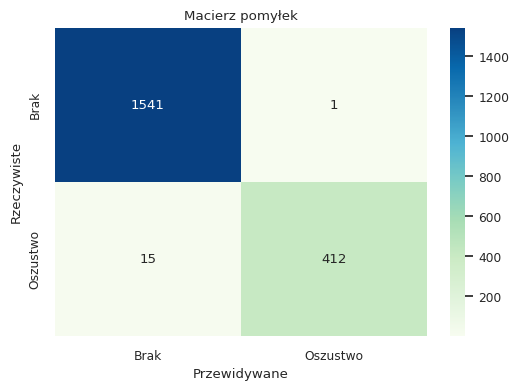

Wynik klasyfikacji:
+----------+------------+-----------+------------+
| Klasa    | Precyzja   | Czułość   |   F1-score |
+==========+============+===========+============+
|          |            |           |            |
+----------+------------+-----------+------------+
| Brak     | 1.00       | 0.99      |       1542 |
+----------+------------+-----------+------------+
| Oszustwo | 0.96       | 0.98      |        427 |
+----------+------------+-----------+------------+


In [27]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
class_names = ['Brak', 'Oszustwo']
ConfusionMatrix(y_test, y_pred)
formatuj_macierz(y_test, y_pred)


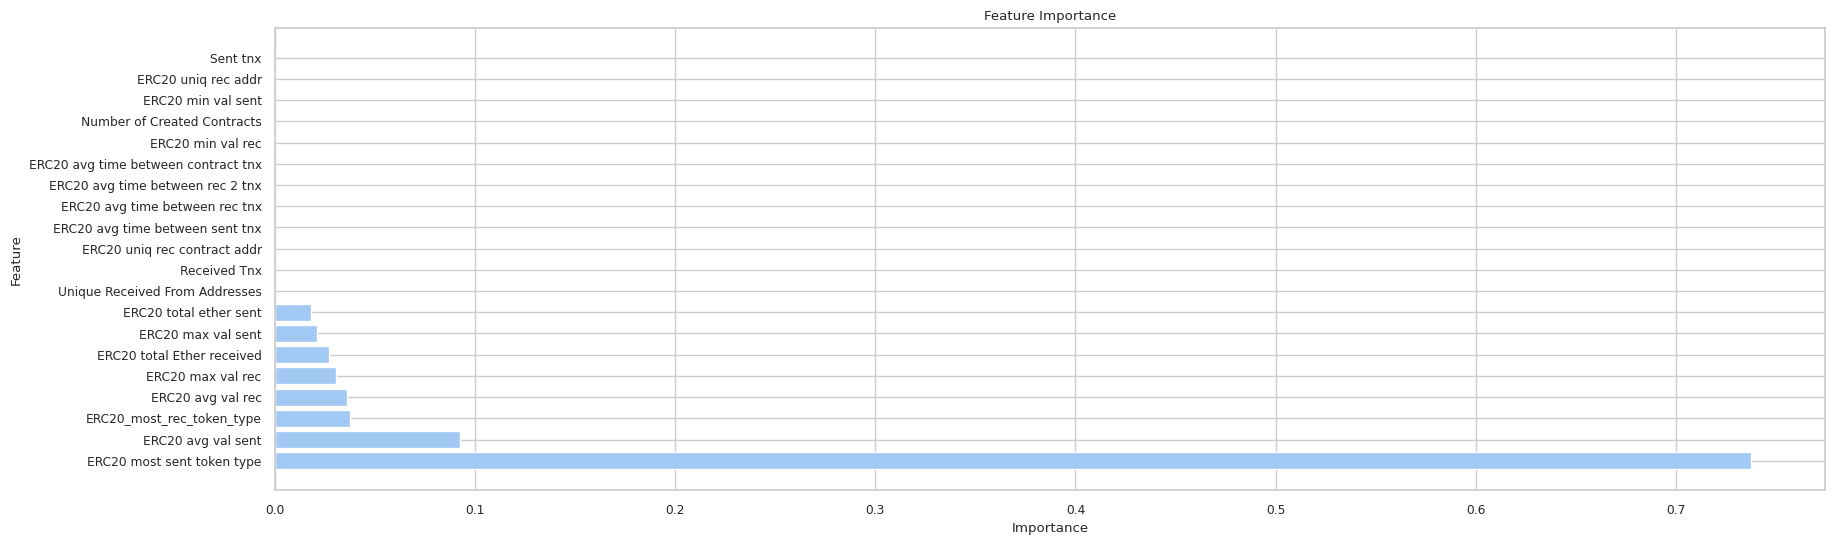

In [ ]:
model=clf
importance = model.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# szukanie optymalnej konfiguracji hiperparametrów dla klasyfikatora XGBoost w celu uzyskania jak najlepszego wyniku na zbiorze testowym
clf = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1000,1500,100),
    'learning_rate': [0.1, 0.01, 0.05]
}
tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=2,
                         )

tuned_clf.fit(X_train,y_train)



Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   5.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   6.1s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   4.5s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   6.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   5.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   7.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   6.1s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   8.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   4.7s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=  10.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1200; total time=   7.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_e

In [ ]:
print("Tuned Hyperparameters :", tuned_clf.best_params_)
print("Train F1 Score :",tuned_clf.best_score_)
best_y_pr = tuned_clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

In [ ]:
tuned_clf.best_estimator_

In [ ]:
tuned_clf.best_score_

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
#szacowanie test error rate za pomocą k-fold cross_validation:

classifier = LogisticRegression()
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(classifier, X_data, y_data, cv=k_fold, scoring='accuracy')

print("Cross-validation results:", cv_results)
print("Mean accuracy:", cv_results.mean())

Cross-validation results: [0.80650076 0.79878049 0.8023374  0.80182927 0.80284553]
Mean accuracy: 0.8024586889469708


 Regresja logistyczna:

Macierz pomyłek:


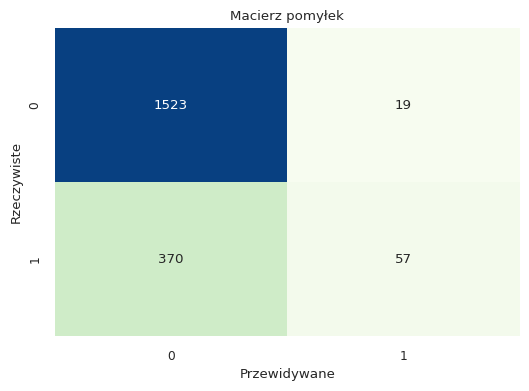

Wynik klasyfikacji:
+----------+------------+-----------+------------+
| Klasa    | Precyzja   | Czułość   |   F1-score |
+==========+============+===========+============+
|          |            |           |            |
+----------+------------+-----------+------------+
| Brak     | 0.99       | 0.89      |       1542 |
+----------+------------+-----------+------------+
| Oszustwo | 0.13       | 0.23      |        427 |
+----------+------------+-----------+------------+


In [ ]:
# Inicjalizacja modelu regresji logistycznej
model2 = LogisticRegression()

# Dopasowanie modelu do danych treningowych
model2.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = model2.predict(X_test)
class_names=['Brak', 'Oszustwo']

# Ocena wyników klasyfikacji
print("Macierz pomyłek:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="GnBu", fmt='g', cbar=False)
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz pomyłek')
plt.show()
formatuj_macierz(y_test, y_pred, class_names)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Inicjalizacja modelu drzewa decyzyjnego
model = DecisionTreeClassifier(random_state=42)

# Dopasowanie modelu do danych treningowych
model.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred = model.predict(X_test)

# Ocena dokładności modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu drzewa decyzyjnego:", accuracy)


Dokładność modelu drzewa decyzyjnego: 0.8908075165058406


In [ ]:
# Macierz pomyłek dla drzewa decyzyjnego:
print("Macierz pomyłek:")
formatuj_macierz(y_test, y_pred)

Macierz pomyłek:
Wynik klasyfikacji:
+----------+------------+-----------+------------+
| Klasa    | Precyzja   | Czułość   |   F1-score |
+==========+============+===========+============+
|          |            |           |            |
+----------+------------+-----------+------------+
| Brak     | 0.99       | 0.93      |       1542 |
+----------+------------+-----------+------------+
| Oszustwo | 0.55       | 0.69      |        427 |
+----------+------------+-----------+------------+


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Eksport drzewa decyzyjnego do pliku dot
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_data_encoded.columns,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)

# Konwersja danych dot do obiektu grafu
graph = graphviz.Source(dot_data)

# Wyświetlenie grafu
graph.render("decision_tree")  # Zapis do pliku PNG
graph.view()  # Wyświetlenie grafu


'decision_tree.pdf'